In [139]:
#导入PyTorch
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np

In [140]:
#GPU设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [141]:
#下载并准备 CIFAR10 数据集

#CIFAR10 数据集包含10类，共60000张彩色图片，每类图片有  6000张。此数据集中  50000个样例被作为训练集，剩余  10000个样例作为测试集。类之间相互独立，不存在重叠的部分。
# 使用 torchvision 加载并规范化 CIFAR10 训练和测试数据集。torchvision 数据集的输出是范围为 [0,1] 的 PILImage 图像。我们将它们转换为归一化范围 [-1，1] 的张量:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

In [142]:
#加载训练集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

Files already downloaded and verified


In [143]:
#加载测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

In [144]:
#验证数据
# 我们将测试集的前  25张图片和类名打印出来，来确保数据集被正确加载。CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ a叩lane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。

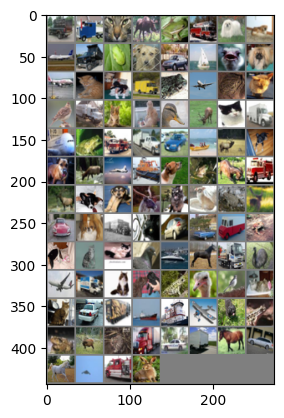

truck truck   cat  deer  frog truck   dog   dog plane truck  frog   dog   car  ship  bird   dog plane   cat   dog truck  frog plane  frog   cat  bird truck   cat   cat  bird  deer   cat truck plane  frog truck truck   car  ship  deer   dog   dog  deer plane  ship   dog  frog horse truck  deer   dog   dog  deer   cat   dog  frog  deer   car   dog truck   cat   car   car truck  frog   dog   cat   cat  bird  ship horse truck  bird plane truck   cat   dog  frog  bird  bird   cat   cat   car truck  ship  ship plane   dog  frog  frog  deer  frog truck   car truck horse   car horse plane truck  deer


In [145]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [146]:
#构造 LeNet 神经网络模型
from torch import nn
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1,padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,inputs):
        batch_size = inputs.shape[0]
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.reshape(batch_size,16*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        outputs = self.fc3(x)
        return outputs

In [147]:
#查看完整的 CNN 结构：
net = LeNet()
net = net.to(device)
net

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [148]:
#编译并训练模型

In [149]:
#让我们使用分类交叉熵损失和 Adam 优化方法:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)

In [150]:
#开始训练
loss_list = []
for epoch in range(5):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        # 获取输入， data 为列表 [inputs,labels]
        inputs,labels = data
        inputs,labels = inputs.to(device),labels.to(device)
        # 将参数梯度归零
        optimizer.zero_grad()
        
        # 正向传播+反向传播+优化
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i+1)%100 == 0:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            loss_list.append(running_loss / 100)
            running_loss = 0.0
print('Finished Training')

[1,   100] loss: 1.995
[1,   200] loss: 1.700
[1,   300] loss: 1.594
[1,   400] loss: 1.552
[1,   500] loss: 1.529
[2,   100] loss: 1.464
[2,   200] loss: 1.433
[2,   300] loss: 1.425
[2,   400] loss: 1.383
[2,   500] loss: 1.369
[3,   100] loss: 1.325
[3,   200] loss: 1.307
[3,   300] loss: 1.295
[3,   400] loss: 1.286
[3,   500] loss: 1.263
[4,   100] loss: 1.228
[4,   200] loss: 1.214
[4,   300] loss: 1.208
[4,   400] loss: 1.195
[4,   500] loss: 1.186
[5,   100] loss: 1.148
[5,   200] loss: 1.148
[5,   300] loss: 1.136
[5,   400] loss: 1.144
[5,   500] loss: 1.131
Finished Training


In [151]:
#让我们快速保存经过训练的模型：
PATH = './cifar_net.pth'
torch.save(net, PATH)

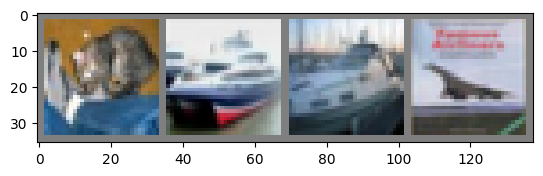

GroundTruth:    cat  ship  ship plane


In [152]:
#图片输出
# 我们已通过训练数据集对网络进行了多次次训练。但我们需要检查网络是否学到了任何东西。我们将通过预测神经网络输出的类标签，并根据基本事实进行检查来检查这一点。如果预测是正确的，我们将样本添加到正确预测列表中。让我们显示一个来自测试集的图像以熟悉它。
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [153]:
images.numpy().shape

(100, 3, 32, 32)

In [154]:
#现在让我们看看神经网络认为上面这些例子是什么：
outputs = net(images)

In [155]:
#输出为  10类的能量。一个类的能量越高，网络就越认为图像属于特定的类。那么，让我们得到最高能量的指数：
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [156]:
#评估模型
# 输出在验证集上的精度：
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %.4f %%' % (
    100.0 * correct / total))

Accuracy of the network on the 10000 test images: 58.8700 %


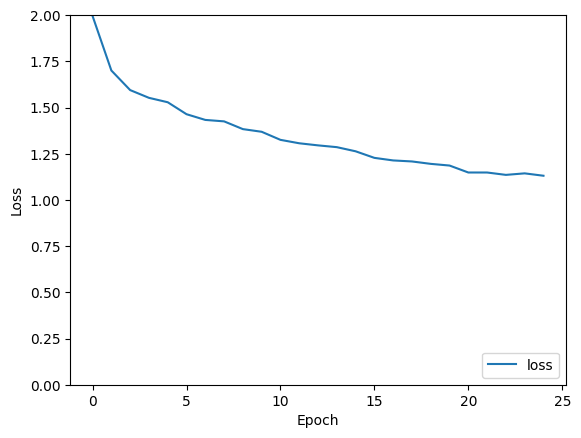

In [157]:
#下面是训练过程中损失函数的变化：
plt.plot(loss_list, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')
plt.show()

In [158]:
#此处导入一张新的图片：
import cv2
import numpy as np
from torch import Tensor
path = "./images/horse.png"
image=cv2.imread(path)
res = cv2.resize(image,(32,32),interpolation=cv2.INTER_CUBIC)
res = res/255.0
res = (res-0.5)/0.5
np.array(res).shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137254901961].


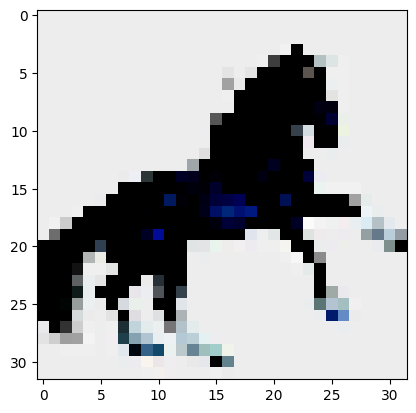

In [159]:
#输出图片
plt.imshow(res, cmap=plt.cm.binary)

In [160]:
#将 HWC 转化为 CHW
res = res.transpose(2, 0, 1)

In [161]:
#通过神经网络输出
res = res.reshape(-1,3,32,32)
out = net(Tensor(res))
out = out.detach().numpy()
out

array([[ 0.6896309,  0.6564265,  0.9132004, -2.4399493, -3.9369025,
        -2.4774518, -2.8367689,  3.447829 , -9.007268 ,  2.6946554]],
      dtype=float32)

In [162]:
#输出预测标签
label = classes[np.argmax(out)]
label

'horse'